<a href="https://colab.research.google.com/github/shuvranaim/image_caption/blob/main/Image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

#!pip install cartopy
#import cartopy

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

image_path = "/content/drive/MyDrive/1-3000"
dir_Flickr_text = "/content/drive/MyDrive/5-5500.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 4920


In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1.png,তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই...
1,1,1.png,একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে এ...
2,2,1.png,একটি নীল রঙের দেয়ালের সামনে হলুদ জামা পায়জামা...
3,3,1.png,হলুদ জামা পায়জামা পরা মহিলা দাঁড়িয়ে হাতে একটি...
4,4,1.png,একজন মহিলা একটি মেয়েকে পিটানোর ভাব দেখাচ্ছে এব...


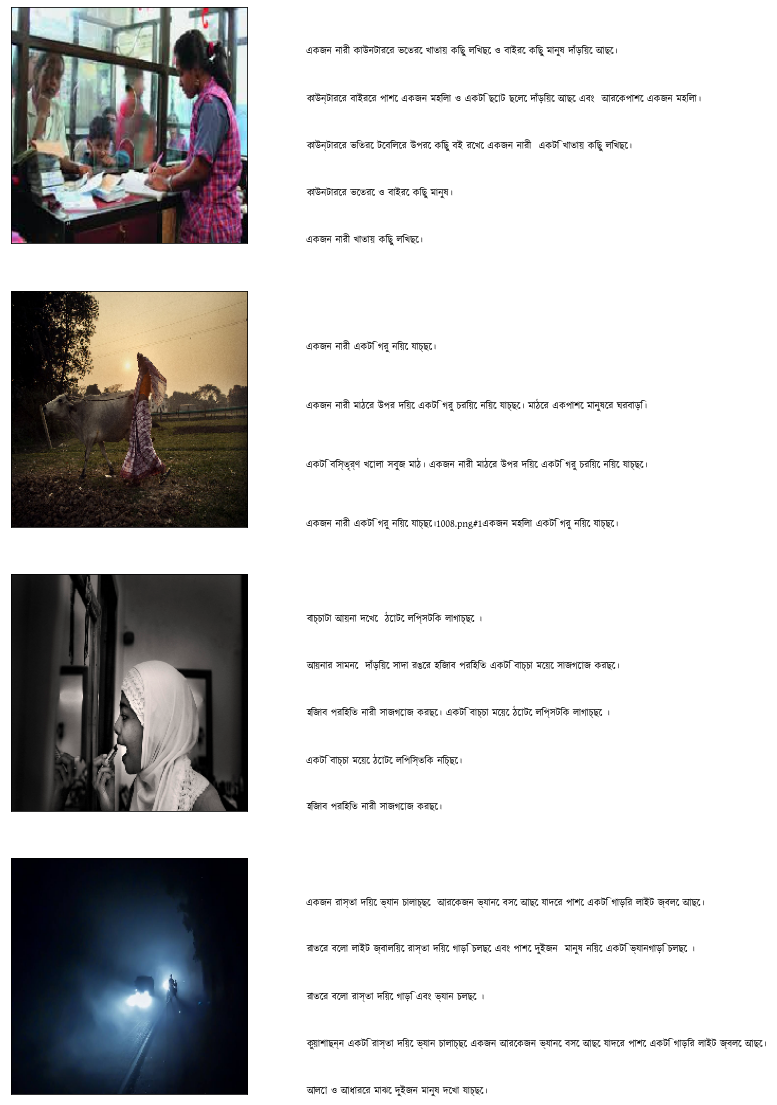

In [ ]:
import matplotlib.font_manager as fm
prop=fm.FontProperties(fname='/content/drive/MyDrive/Kalpurush.ttf')
import matplotlib.pyplot as plt
npic = 4
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=40,fontproperties= prop)
   count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
#vocabulary

Vocabulary Size: 7249


In [ ]:
PATH = "/content/drive/MyDrive/1000image/"
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start> তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে। <end>',
 '<start> একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। <end>',
 '<start> একটি নীল রঙের দেয়ালের সামনে  হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে।  <end>',
 '<start> হলুদ জামা পায়জামা পরা মহিলা  দাঁড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। আরেকটি মেয়ে ঘরের ভিতরে বসে দেখছে । <end>',
 '<start> একজন মহিলা একটি মেয়েকে পিটানোর ভাব দেখাচ্ছে এবং কালো হিজাব পরা একটি ছোট মেয়ে ঘরের ভিতর থেকে বসে দেখছে। <end>',
 '<start> জলাশয়ের পাড়ে একজন লোক নৌকার উপরে দাঁড়িয়ে আছে এবং একটি ছোট ছেলে নৌকা ধরে দাঁড়িয়ে আছে । <end>',
 '<start> জলাশয়ের পাড়ে একজন লোক বৈঠা হাতে নিয়ে নৌকার উপরে দাঁড়িয়ে আছে এবং একটি ছোট ছেলে নৌকা ধরে দাঁড়িয়ে আছে । <end>',
 '<start> জলাশয়ের পাড়ে নীল গেঞ্জি ও সাদা লুঙ্গি পরা একজন লোক নৌকার উপরে দাঁড়িয়ে আছে এবং এক

In [ ]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/content/drive/MyDrive/1000image/1.png',
 '/content/drive/MyDrive/1000image/1.png',
 '/content/drive/MyDrive/1000image/1.png',
 '/content/drive/MyDrive/1000image/1.png',
 '/content/drive/MyDrive/1000image/1.png',
 '/content/drive/MyDrive/1000image/2.png',
 '/content/drive/MyDrive/1000image/2.png',
 '/content/drive/MyDrive/1000image/2.png',
 '/content/drive/MyDrive/1000image/2.png',
 '/content/drive/MyDrive/1000image/2.png']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 4996
len(all_captions) : 4996


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(2000,all_captions,all_img_name_vector)

In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())

100%|██████████| 15/15 [07:46<00:00, 31.11s/it]

CPU times: user 14min 7s, sys: 7.79 s, total: 14min 15s
Wall time: 7min 46s


In [ ]:
top_k = 1500
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 42 : 4


In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [ ]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x  

In [ ]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [ ]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))




In [ ]:
encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [ ]:
EPOCHS = 10
for epoch in range( EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.6463
Epoch 1 Loss 0.615363
Time taken for 1 epoch 84.74288129806519 sec

Epoch 2 Batch 0 Loss 0.5268
Epoch 2 Loss 0.554378
Time taken for 1 epoch 84.272207736969 sec

Epoch 3 Batch 0 Loss 0.4249
Epoch 3 Loss 0.506780
Time taken for 1 epoch 83.84344577789307 sec

Epoch 4 Batch 0 Loss 0.4749
Epoch 4 Loss 0.462683
Time taken for 1 epoch 83.77839684486389 sec

Epoch 5 Batch 0 Loss 0.4839
Epoch 5 Loss 0.431671
Time taken for 1 epoch 84.19468665122986 sec

Epoch 6 Batch 0 Loss 0.3126
Epoch 6 Loss 0.394778
Time taken for 1 epoch 84.3370292186737 sec

Epoch 7 Batch 0 Loss 0.3184
Epoch 7 Loss 0.374719
Time taken for 1 epoch 84.44572257995605 sec

Epoch 8 Batch 0 Loss 0.3036
Epoch 8 Loss 0.343554
Time taken for 1 epoch 83.98747897148132 sec

Epoch 9 Batch 0 Loss 0.2985
Epoch 9 Loss 0.318820
Time taken for 1 epoch 84.17322015762329 sec

Epoch 10 Batch 0 Loss 0.2741
Epoch 10 Loss 0.297066
Time taken for 1 epoch 83.98678541183472 sec



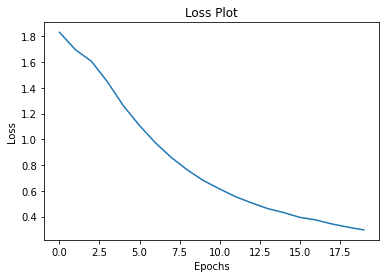

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)

   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (10, 10))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l],fontproperties= fm.FontProperties(fname='/content/drive/MyDrive/Kalpurush.ttf'))
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import accuracy_score

BELU score: 36.55552228545123
Real Caption: একজন মহিলার হাতের চামড়াই সমস্যা হইছে আর সে তা দেখাচ্ছে ।
Prediction Caption: একজন মহিলার হাতের চামড়াই সমস্যা হইছে আর সে তা দেখাচ্ছে ।


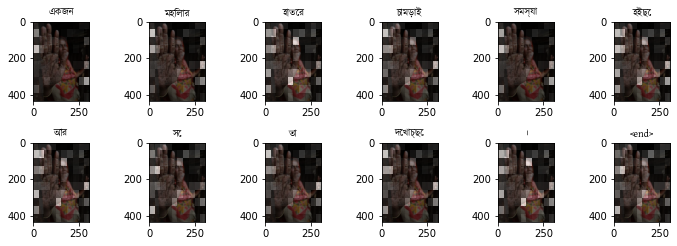

time took to Predict: 2 sec


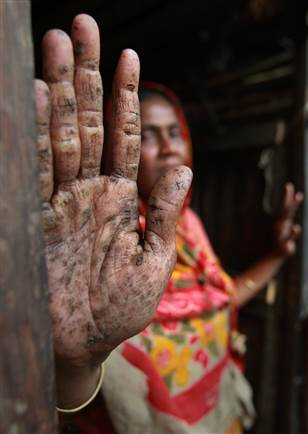

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]


start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])